In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import sklearn
from matplotlib import pyplot as plt


import json
import joblib

import rdkit

import sys
sys.path.append('../')


# Утилитарные классы

In [2]:
from config.experiment_config import config
from utils.data_utils import data_utils

/mnt/Supermicro/data2/test-syntelly/.conda/lib/python3.11/site-packages/datasail/settings.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
sh: 1: cd-hit: not found
sh: 1: cd-hit-est: not found
sh: 1: diamond: not found
sh: 1: mmseqs: not found
sh: 1: mmseqs: not found
sh: 1: mmseqs: not found
sh: 1: mash: not found
sh: 1: foldseek: not found
sh: 1: TMalign: not found


# EDA 

In [3]:
boil_data = pd.read_csv(config.DATA_PATH / 'boiling_points.csv')
boil_data.head()

,smiles,value,source,name,units,params
0,CC1(C)c2ccccc2-c2ccc(N(c3ccc4c(c3)C3(c5ccccc5-...,500.000,ECHA,Boiling point,°C,NaN
1,Cc1ccc(C=CCl)cc1,223.000,NaN,Boiling point,°C,NaN
2,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,929.624,NaN,Boiling point,°C,NaN
3,CC=Cc1ccc(OCC)cc1,242.000,NaN,Boiling point,°C,NaN
4,CCCCCCCCCCc1cccc2ccccc12,379.000,Handbook of chemistry and physics 2016,Boiling point,°C,NaN


In [4]:
melt_data = pd.read_csv(config.DATA_PATH / 'melting_points.csv')
melt_data.head()

,smiles,value,source,name,units,params
0,CC1(C)c2ccccc2-c2ccc(N(c3ccc4c(c3)C3(c5ccccc5-...,255.800000,ECHA,Melting point,°C,NaN
1,Cc1ccc(C=CCl)cc1,35.500000,NaN,Melting point,°C,NaN
2,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,194.000000,NaN,Melting point,°C,NaN
3,CC=Cc1ccc(OCC)cc1,60.333332,NaN,Melting point,°C,NaN
4,CCCCCCCCCCc1cccc2ccccc12,15.000000,NaN,Melting point,°C,NaN


In [5]:
boil_data = boil_data.rename(columns={'value': 'boil_value', 
                                      'source': 'boil_source', 
                                      'name': 'boil_name', 
                                      'units': 'boil_units', 
                                      'params': 'boil_params'})
melt_data = melt_data.rename(columns={'value': 'melt_value', 
                                      'source': 'melt_source',
                                      'name': 'melt_name', 
                                      'units': 'melt_units', 
                                      'params': 'melt_params'})

Рассмотрим boil_data

In [6]:
boil_data.describe()

,boil_value,boil_params
count,11699.000000,0.0
mean,225.675892,NaN
std,118.290078,NaN
min,-191.500000,NaN
25%,151.000000,NaN
50%,218.000000,NaN
75%,282.975000,NaN
max,2262.000000,NaN


In [7]:
boil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11699 entries, 0 to 11698
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   smiles       11699 non-null  object 
 1   boil_value   11699 non-null  float64
 2   boil_source  7854 non-null   object 
 3   boil_name    11699 non-null  object 
 4   boil_units   11699 non-null  object 
 5   boil_params  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 548.5+ KB


In [8]:
for col in boil_data.columns:
    print(f'Пропуски в колонке {col}: {boil_data[col].isna().sum()}')

Пропуски в колонке smiles: 0
Пропуски в колонке boil_value: 0
Пропуски в колонке boil_source: 3845
Пропуски в колонке boil_name: 0
Пропуски в колонке boil_units: 0
Пропуски в колонке boil_params: 11699


In [9]:
boil_data['boil_name'].unique()

array(['Boiling point'], dtype=object)

In [10]:
boil_data['boil_units'].unique()

array(['°C'], dtype=object)

In [11]:
boil_data['smiles'].duplicated().sum()

0

Рассмотрим melt_data

In [12]:
melt_data.describe()

,melt_value,melt_params
count,11699.000000,0.0
mean,31.028137,NaN
std,91.192914,NaN
min,-205.020000,NaN
25%,-27.475000,NaN
50%,25.500000,NaN
75%,78.000000,NaN
max,1300.000000,NaN


In [13]:
melt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11699 entries, 0 to 11698
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   smiles       11699 non-null  object 
 1   melt_value   11699 non-null  float64
 2   melt_source  5690 non-null   object 
 3   melt_name    11699 non-null  object 
 4   melt_units   11699 non-null  object 
 5   melt_params  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 548.5+ KB


In [14]:
for col in melt_data.columns:
    print(f'Пропуски в колонке {col}: {melt_data[col].isna().sum()}')

Пропуски в колонке smiles: 0
Пропуски в колонке melt_value: 0
Пропуски в колонке melt_source: 6009
Пропуски в колонке melt_name: 0
Пропуски в колонке melt_units: 0
Пропуски в колонке melt_params: 11699


In [15]:
melt_data['melt_name'].unique()

array(['Melting point'], dtype=object)

In [16]:
melt_data['melt_units'].unique()

array(['°C'], dtype=object)

In [17]:
melt_data['smiles'].duplicated().sum()

0

Если рассматривать датасеты глазами, то можно заметить, что это одно множество химических соединений. Попробуем это подтвердить

In [18]:
boil_set = set(boil_data['smiles'])
melt_set = set(melt_data['smiles'])

missing_rows = boil_set - melt_set 
print(f'Значение разницы множеств: {len(missing_rows)}')

Значение разницы множеств: 0


Для удобства дальнейшей работы мы не будем объединять датафреймы в единый

## Визуализация распределений значений таргета

### Boil_data

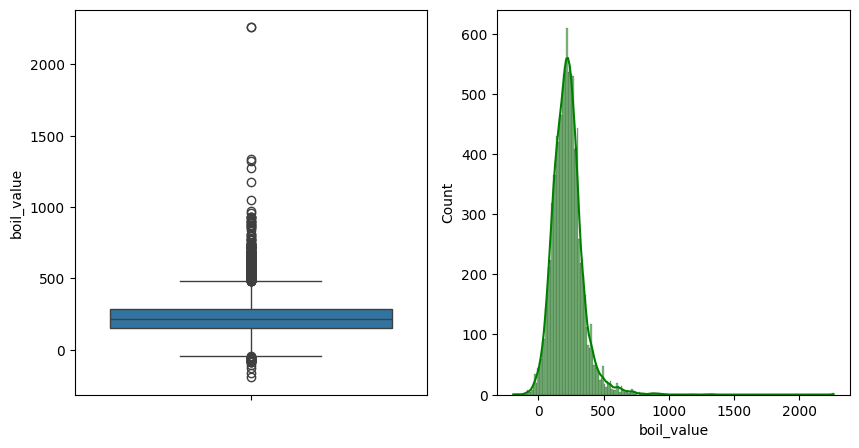

In [19]:
data_utils.plot_target(boil_data['boil_value'])

На графиках можем увидеть большое количество выбросов за межквартильным размахом. Распределение очевидно стремится к форме негативного биномиального распределения за счёт высокого смещения. Дополнительно применим тест Колмогорова-Смирнова (Шапиро-Уилка стоит использовать на меньших выборках) и skewness/kurtosis на нормальность распределения.

In [20]:
data_utils.check_normality(boil_data['boil_value'])

КС-тест = 0.07513711891339248
p-value = 6.915447579828496e-58
Сдвиг: 2.077678742125133
Эксцесс: 20.00814397753698


Ожидаемо тест указывает на существенное отклонение от нормального распределения

### Melt_data

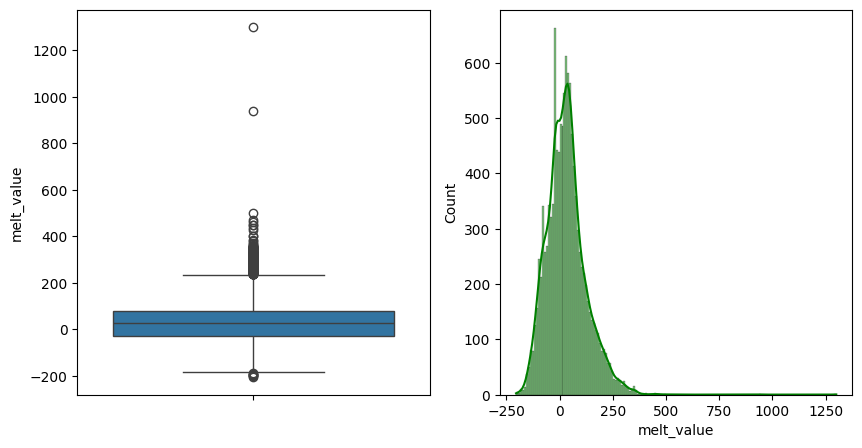

In [21]:
data_utils.plot_target(melt_data['melt_value'])

In [22]:
data_utils.check_normality(melt_data['melt_value'])

КС-тест = 0.059896031519825255
p-value = 6.3106202750783694e-37
Сдвиг: 0.927336801487915
Эксцесс: 4.642410273057551


То же самое наблюдаем для данных температуры плавления

## Удаление выбросов с помощью правила 3 сигм (z-score)

### Boil_data

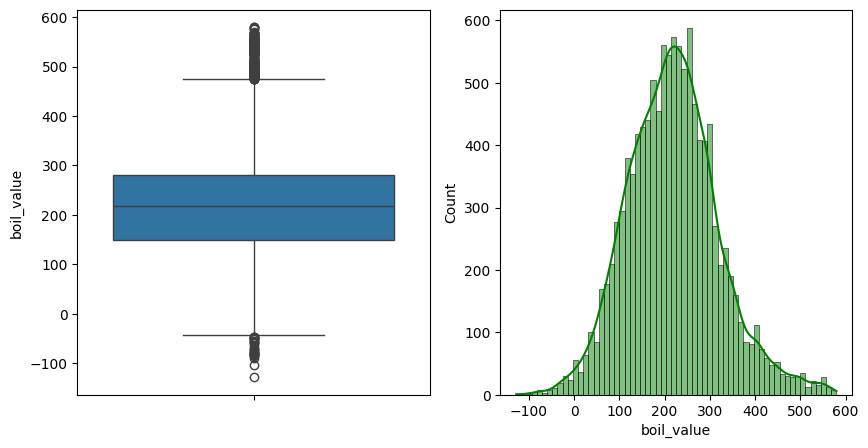

In [23]:
outliers_mask = data_utils.get_outliers_mask(boil_data['boil_value'])
boil_clean = boil_data[~outliers_mask]
data_utils.plot_target(boil_clean['boil_value'])

In [24]:
data_utils.check_normality(boil_clean['boil_value'])

КС-тест = 0.032288281239705174
p-value = 6.811918591856513e-11
Сдвиг: 0.3563562276942144
Эксцесс: 0.517271389808335


Видим значительное улучшение как визуальной формы распределения, так и статистических тестов. КС-тест всё ещё показывает значительное отклонение от нормальности, возможно, статистически будет верно использовать в качестве "отсеивания" межквартильный размах, но стоит сохранить большее количество данных для обучения моделей

In [25]:
print(f'Итоговая разница размерностей: {boil_data.shape[0] - boil_clean.shape[0]}')

Итоговая разница размерностей: 152


### Melt_data

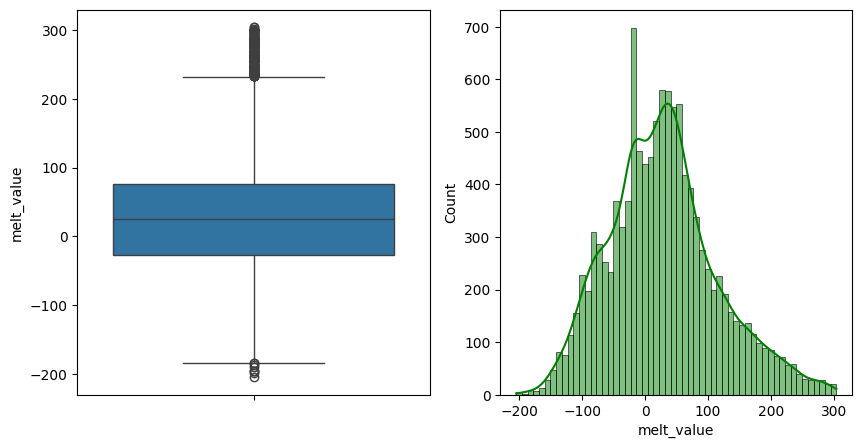

In [26]:
outliers_mask = data_utils.get_outliers_mask(melt_data['melt_value'])
melt_clean = melt_data[~outliers_mask]
data_utils.plot_target(melt_clean['melt_value'])

In [27]:
data_utils.check_normality(melt_clean['melt_value'])

КС-тест = 0.04727760456453045
p-value = 5.377045650933815e-23
Сдвиг: 0.448824274789007
Эксцесс: 0.15993696927322487


In [28]:
print(f'Итоговая разница размерностей: {melt_data.shape[0] - melt_clean.shape[0]}')

Итоговая разница размерностей: 86


# Разделение данных

В качестве средства для разделения по train-test выборкам будем использовать [DataSail](https://github.com/kalininalab/DataSAIL) в соотношении 80/20, чтобы предотвратить возможную утечку данных между фолдами

In [ ]:
boil_clean.reset_index(inplace=True)
boil_split = data_utils.datasail_split(boil_clean)

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Charges were rearranged

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Charges were rearranged

[17:59:15] WARNING: Charges were rearranged

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined stereo

[17:59:15] WARNING: Omitted undefined

In [ ]:
melt_clean.reset_index(inplace=True)
melt_split = data_utils.datasail_split(melt_clean)